### 1. Data Aggregation and Preprocessing

In this step, we aggregate and preprocess various datasets to create a comprehensive dataset for analysis.

1. **Data Sources**:
   - **Candle Data**: Utilize the provided dataset for historical data, and optionally augment it with real-time data from centralized exchanges (CEXs) using APIs, like the Binance API.
   - **Sentiment Data**: Integrate sentiment analysis data from social media (e.g., Twitter) or news sources to capture public sentiment trends and their potential impact on asset prices.

2. **Data Aggregation**:
   - **Timestamp Synchronization**: Align data across sources using timestamps to enable seamless time series analysis.
   - **Standardization**: Ensure uniform data formats, units, and naming conventions to streamline processing and analysis.
   - **Preprocessing**: Transform sentiment data (e.g., social media posts or news) into numerical sentiment scores or keyword vectors that represent market sentiment impacts on asset price trends.

This aggregation and preprocessing step provides a robust and clean dataset for accurate analysis and model development, capturing both market and sentiment indicators essential for informed strategy design.


### Data Save Path Setup

We set up a `data_save_path` pointing to a "data" folder located one level above the root directory. This ensures a consistent place for saving files throughout the notebook.

In [2]:
import os

# Define the path to the "data" directory, one level up from the root
data_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'quant_data'))

# Print the path to confirm
print("Data Save Path:", data_save_path)


Data Save Path: /home/suman/projects/encode_hack/quant_data


### Function: Fetch and Save Top 100 Trending Cryptocurrencies

The `get_trending_crypto` function retrieves 24-hour cryptocurrency price data from Binance’s API and:
1. **Sorts**: The data by the highest price change percentage to identify trending assets.
2. **Saves to CSV**: The top 100 trending cryptocurrencies in a CSV file named `top_100_trending_crypto.csv` within `data_save_path`.

In [3]:
import requests
import pandas as pd

def get_trending_crypto():
    url = "https://api.binance.com/api/v3/ticker/24hr"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        # Sort by price change percentage to get trending cryptocurrencies
        trending_crypto = sorted(data, key=lambda x: float(x['priceChangePercent']), reverse=True)
        
        # Get top 100 trending cryptocurrencies
        top_trending = trending_crypto[:100]

        # Create DataFrame and save to CSV in data_save_path
        trending_df = pd.DataFrame(top_trending)
        trending_csv_path = os.path.join(data_save_path, 'top_100_trending_crypto.csv')
        trending_df.to_csv(trending_csv_path, index=False, columns=['symbol', 'priceChangePercent', 'lastPrice'])

        print("Top 100 trending cryptocurrencies CSV has been created successfully.")
        return trending_df
    else:
        print("Error fetching data:", response.status_code)
        return "NA"
    

# Call the function to save top trending cryptocurrencies
trending_df = get_trending_crypto()
trending_df


Top 100 trending cryptocurrencies CSV has been created successfully.


,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,openPrice,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count
0,TROYUSDT,0.00031300,26.391,0.00148264,0.00118600,0.00149900,36711.00000000,0.00149900,100950.00000000,0.00150000,...,0.00118600,0.00169600,0.00112700,14670184563.00000000,21750636.64249700,1729937301209,1730023701209,38649844,38788077,138234
1,SXPTRY,1.15400000,14.831,8.89971688,7.75800000,8.93500000,2685.50000000,8.92000000,2416.50000000,8.93200000,...,7.78100000,9.40000000,7.50200000,9767746.60000000,86930179.27040000,1729937304464,1730023704464,10609893,10622708,12816
2,SXPUSDT,0.03310000,14.692,0.25138730,0.22510000,0.25840000,1681.20000000,0.25810000,1841.40000000,0.25840000,...,0.22530000,0.27330000,0.21740000,41876425.70000000,10527201.53691000,1729937304923,1730023704923,133031019,133112719,81701
3,SXPBTC,0.00000049,14.583,0.00000379,0.00000337,0.00000385,12977.40000000,0.00000384,3650.50000000,0.00000386,...,0.00000336,0.00000427,0.00000326,1578887.70000000,5.98929508,1729937304708,1730023704708,25658007,25660433,2427
4,RAYBNB,0.00067400,13.458,0.00529946,0.00496400,0.00568200,52.40000000,0.00561600,60.80000000,0.00568600,...,0.00500800,0.00580300,0.00500700,70875.90000000,375.60400950,1729937231789,1730023631789,964724,965905,1182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SOLETH,0.00186000,2.709,0.06930995,0.06866000,0.07051000,0.53700000,0.07050000,25.54200000,0.07051000,...,0.06865000,0.07089000,0.06805000,51344.78600000,3558.70465730,1729937304498,1730023704498,15452684,15497281,44598
96,PYTHBTC,0.00000014,2.697,0.00000525,0.00000518,0.00000533,468.30000000,0.00000531,14422.20000000,0.00000533,...,0.00000519,0.00000543,0.00000510,220463.20000000,1.15669451,1729937303695,1730023703695,639610,640017,408
97,SOLBTC,0.00006790,2.686,0.00255202,0.00252750,0.00259560,0.38500000,0.00259550,131.93600000,0.00259560,...,0.00252770,0.00261100,0.00250610,259122.78600000,661.28779457,1729937304678,1730023704678,121793110,121984921,191812
98,IOBNB,0.00007900,2.676,0.00296826,0.00292300,0.00303100,264.58000000,0.00302000,321.10000000,0.00303900,...,0.00295200,0.00311000,0.00286600,17610.00000000,52.27109894,1729937288598,1730023688598,199826,200062,237


### Function: Fetch and Save Top 100 Most Valued Cryptocurrencies

The `get_most_valued_crypto` function retrieves the same data from Binance’s API and:
1. **Sorts**: The data by the highest `lastPrice` value to identify the most valued assets.
2. **Saves to CSV**: The top 100 most valued cryptocurrencies in a CSV file named `top_100_valued_crypto.csv` within `data_save_path`.

This split allows more granular data handling, with each function focused on a single type of analysis and CSV generation.

In [4]:
import requests
import pandas as pd

def get_most_valued_crypto():
    url = "https://api.binance.com/api/v3/ticker/24hr"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        # Sort by last price to get most valued cryptocurrencies
        most_valued_crypto = sorted(data, key=lambda x: float(x['lastPrice']), reverse=True)

        # Get top 100 most valued cryptocurrencies
        top_valued = most_valued_crypto[:100]

        # Create DataFrame and save to CSV in data_save_path
        valued_df = pd.DataFrame(top_valued)
        valued_csv_path = os.path.join(data_save_path, 'top_100_valued_crypto.csv')
        valued_df.to_csv(valued_csv_path, index=False, columns=['symbol', 'lastPrice', 'priceChangePercent'])

        print("Top 100 most valued cryptocurrencies CSV has been created successfully.")

        return valued_df
    else:
        print("Error fetching data:", response.status_code)

        return valued_df

# Call the function to save top valued cryptocurrencies
get_most_valued_crypto()


Top 100 most valued cryptocurrencies CSV has been created successfully.


,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,openPrice,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count
0,BTCARS,-365129.00000000,-0.460,79084247.37729003,79307221.00000000,78991801.00000000,0.00015000,78991804.00000000,0.00021000,79081196.00000000,...,79356930.00000000,79450099.00000000,78800000.00000000,1.02510000,81069261.98646000,1729937225768,1730023625768,1111659,1113038,1380
1,BTCJPY,5094.00000000,0.050,10221499.48275232,10221050.00000000,10227109.00000000,0.00075500,10225708.00000000,0.00001200,10229847.00000000,...,10222015.00000000,10268335.00000000,10175700.00000000,8.48070700,86685542.21387400,1729937306457,1730023706457,2371767,2375594,3828
2,BTCUAH,-2998.00000000,-0.102,2945690.46498831,2944998.00000000,2946053.00000000,0.00546000,2941253.00000000,0.00149000,2946197.00000000,...,2949051.00000000,2957900.00000000,2927228.00000000,0.14538000,428244.47980000,1729937283415,1730023683415,2303034,2303202,169
3,ETHARS,-12490.00000000,-0.423,2925365.90437191,2920203.00000000,2941912.00000000,0.01442000,2872715.00000000,0.01448000,2920812.00000000,...,2954402.00000000,2954402.00000000,2860675.00000000,1.01832000,2978958.60774000,1729937232230,1730023632230,16137,16159,23
4,BTCTRY,6517.00000000,0.282,2316747.75418968,2312614.00000000,2319346.00000000,0.00178000,2319345.00000000,0.00125000,2319346.00000000,...,2312829.00000000,2330797.00000000,2302434.00000000,65.42569000,151574820.37381000,1729937308006,1730023708006,55765280,55794177,28898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SOLEUR,4.45000000,2.832,158.56555472,157.07000000,161.60000000,0.25900000,161.54000000,18.26900000,161.60000000,...,157.15000000,162.69000000,155.08000000,12310.24600000,1951980.98577000,1729937297037,1730023697037,16126855,16133912,7058
96,PENDLETRY,0.00000000,0.000,155.96657743,154.70000000,155.00000000,65.20000000,154.80000000,503.90000000,155.00000000,...,155.00000000,158.50000000,153.10000000,26372.30000000,4113197.37000000,1729937304268,1730023704268,1206714,1207650,937
97,ATOMTRY,-3.00000000,-1.963,150.62234427,153.10000000,149.80000000,33.23100000,150.00000000,25.59500000,150.10000000,...,152.80000000,153.10000000,148.70000000,30026.65100000,4522684.56430000,1729937303686,1730023703686,2485365,2486369,1005
98,AVAXBRL,-1.60000000,-1.084,145.68478697,147.20000000,146.00000000,35.08000000,146.20000000,13.36000000,146.40000000,...,147.60000000,148.00000000,143.50000000,553.67000000,80661.29600000,1729937268741,1730023668741,870226,870350,125


### Function: `get_binance_bitcoin_data`

This function retrieves per-minute candlestick data for a specified cryptocurrency symbol from Binance's API, aggregates the data for a defined number of days, and saves it to a CSV file in a specified output folder.

#### Parameters
- **symbol** (str): The trading pair symbol to fetch data for (default: `'BTCUSDT'`).
- **num_days** (int): The number of past days to retrieve data (default: 7).

#### Imports and Configuration
This function relies on:
- The **Binance API** to fetch 1-minute interval OHLCV data.
- Configuration variables from `config.py`:
  - `SYMBOLS_CSV_PATH`: Path to CSV file with trading symbols.
  - `START_TIME`: Start date and time for data collection.
  - `NUM_DAYS`: Number of days to fetch for each symbol.
  - `OUTPUT_FOLDER_PATH`: Path where CSV files are saved.

#### Process Overview
1. **Setup**:
   - Converts `START_TIME` from `config.py` to a datetime object.
   - Initializes an empty DataFrame to hold all the retrieved data.

2. **Data Collection**:
   - Loops over each day within the specified `num_days`, fetching data in chunks of 1,000 records due to API limits.
   - Each call to the Binance API retrieves data for a specific `symbol` from `startTime`, using `interval='1m'` to capture per-minute data.
   - If data is received, it is converted into a DataFrame and appended to `all_data`. The loop continues until reaching the end of the current day or if no further data is available.

3. **Data Processing**:
   - Ensures the `Open Time` column is converted to a readable UTC datetime format for easy analysis.
   - Sorts all data by `Open Time` in ascending order, ensuring chronological order.

4. **Data Export**:
   - Saves the aggregated data as a CSV file in `OUTPUT_FOLDER_PATH`, named as `<symbol>_per_minute_data.csv`.
   - Each file contains columns such as `Open Time`, `Open`, `High`, `Low`, `Close`, `Volume`, `Close Time`, `Quote Asset Volume`, `Number of Trades`, `Taker Buy Base Asset Volume`, and `Taker Buy Quote Asset Volume`.

#### Example Usage

```python
# Example: Fetch 7 days of per-minute data for 'BTCUSDT'
get_binance_bitcoin_data(symbol='BTCUSDT', num_days=7)


In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from config import SYMBOLS_CSV_PATH, START_TIME, NUM_DAYS, NUM_SYMBOLS_TO_FETCH, OUTPUT_FOLDER_PATH
import os

def get_binance_bitcoin_data(symbol='BTCUSDT', num_days=7):
    # Binance API endpoint for candlestick data
    url = "https://api.binance.com/api/v3/klines"
    
    # Convert start_time string to datetime object
    start_time_dt = datetime.strptime(START_TIME, '%Y-%m-%d %H:%M:%S')

    # Initialize a DataFrame to collect all data
    all_data = pd.DataFrame()

    for day in range(num_days):  # Loop for the specified number of days
        # Calculate the current day's start and end time
        current_day_start = start_time_dt - timedelta(days=day)
        end_of_day = current_day_start + timedelta(days=1)

        # Convert current_day_start to milliseconds for the first call
        start_time_ms = int(current_day_start.timestamp() * 1000)

        while start_time_ms < int(end_of_day.timestamp() * 1000):
            # Parameters for fetching per-minute data
            params = {
                'symbol': symbol,
                'interval': '1m',
                'limit': 1000,
                'startTime': start_time_ms
            }

            # Send the GET request to the Binance API
            response = requests.get(url, params=params)
            
            # Check if the response was successful
            if response.status_code == 200:
                data = response.json()
                
                # If no data is returned, break the loop
                if not data:
                    print("No more data available for this day.")
                    break

                # Create a DataFrame for better data handling
                df = pd.DataFrame(data, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
                                                  'Close Time', 'Quote Asset Volume', 'Number of Trades', 
                                                  'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'])
                
                # Convert timestamp to datetime in UTC
                df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')

                # Append to all_data DataFrame
                all_data = pd.concat([all_data, df], ignore_index=True)
                
                # Update start_time for the next chunk to the last fetched Open Time
                start_time_ms = int(df['Open Time'].iloc[-1].timestamp() * 1000) + 1  # +1 to avoid duplicate fetch
            else:
                print("Error fetching data:", response.status_code)
                break  # Exit loop if there's an error

    # Check if all_data is not empty before sorting and saving
    if not all_data.empty:
        # Sort the DataFrame by 'Open Time' from oldest to newest
        all_data.sort_values(by='Open Time', ascending=True, inplace=True)

        # Save all data to CSV in the specified output folder
        output_file_path = os.path.join(OUTPUT_FOLDER_PATH, f'{symbol}_per_minute_data.csv')
        all_data.to_csv(output_file_path, index=False)
        print(f"Data saved to {output_file_path}")
    else:
        print("No data collected for symbol:", symbol)


Configuration is set up.


In [29]:
# Load the CSV file containing symbols
symbols_df = pd.read_csv(os.path.join(data_save_path, 'top_100_trending_crypto.csv'))

# Fetch data for each symbol in the specified range
for index in range(min(NUM_SYMBOLS_TO_FETCH, len(symbols_df))):
    symbol = symbols_df.iloc[index]['symbol']
    print(f"Fetching data for symbol: {symbol}")
    get_binance_bitcoin_data(symbol=symbol, num_days=NUM_DAYS)


Fetching data for symbol: TROYUSDT
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/TROYUSDT_per_minute_data.csv
Fetching data for symbol: MEMEFDUSD
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/MEMEFDUSD_per_minute_data.csv
Fetching data for symbol: MEMEUSDT
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/MEMEUSDT_per_minute_data.csv
Fetching data for symbol: MEMETRY
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/MEMETRY_per_minute_data.csv
Fetching data for symbol: LUMIAUSDT
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/LUMIAUSDT_per_minute_data.csv
Fetching data for symbol: NEIROEUR
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/NEIROEUR_per_minute_data.csv
Fetching data for symbol: NEIROFDUSD
Data saved to /home/suman/projects/encode_hack/quant_data/7_days_data/NEIROFDUSD_per_minute_data.csv
Fetching data for symbol: NEIROUSDT
Data saved to /home/

### Types of Data Extracted and Their Purpose

The data extracted from the Binance API for each cryptocurrency symbol includes various metrics that provide insights into the asset's trading activity over time. Here’s a breakdown of each field and its purpose:

1. **Open Time**
   - **Type**: Timestamp (in milliseconds, converted to datetime)
   - **Purpose**: Marks the beginning of each trading period (1-minute intervals in this case), helping to organize and sequence the data chronologically.

2. **Open**
   - **Type**: Float
   - **Purpose**: The price of the asset at the start of the interval. Useful for tracking price trends and understanding how the price moves over short periods.

3. **High**
   - **Type**: Float
   - **Purpose**: The highest price of the asset during the interval. This is often used to measure volatility or to identify resistance levels in technical analysis.

4. **Low**
   - **Type**: Float
   - **Purpose**: The lowest price of the asset during the interval. Like the high price, it helps measure volatility and can indicate support levels.

5. **Close**
   - **Type**: Float
   - **Purpose**: The price of the asset at the end of the interval. The closing price is often used as a key indicator in technical analysis and forms the basis for various moving averages.

6. **Volume**
   - **Type**: Float
   - **Purpose**: The total trading volume during the interval. High volume indicates significant trading interest and can confirm the strength of price movements.

7. **Close Time**
   - **Type**: Timestamp (in milliseconds, converted to datetime)
   - **Purpose**: Marks the end of each trading interval, complementing the open time and helping to define each 1-minute period.

8. **Quote Asset Volume**
   - **Type**: Float
   - **Purpose**: The total volume traded in terms of the quote currency (e.g., USDT for BTCUSDT). This metric shows the overall value of trades in the quote currency and is another indicator of liquidity.

9. **Number of Trades**
   - **Type**: Integer
   - **Purpose**: Represents the number of individual trades executed during the interval. High trade counts often indicate active trading and high liquidity.

10. **Taker Buy Base Asset Volume**
    - **Type**: Float
    - **Purpose**: The volume of the base asset bought by takers (buyers who accept offers at market price) during the interval. It indicates buying demand and liquidity from market takers.

11. **Taker Buy Quote Asset Volume**
    - **Type**: Float
    - **Purpose**: The volume in the quote currency for taker buy trades. This metric helps quantify the dollar value (or equivalent in quote currency) of buying interest from market takers.

12. **Ignore**
    - **Type**: Placeholder
    - **Purpose**: This field is not used and can be ignored in analysis.

Each of these fields contributes unique information that helps in analyzing trading patterns, price movement, and market sentiment. Together, they provide a comprehensive view of trading activity, allowing for in-depth technical analysis and potential strategy development.


In [6]:
sample_df = pd.read_csv(os.path.join(data_save_path, "7_days_data" , "MEMEFDUSD_per_minute_data.csv"))
sample_df.head(10)

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2024-10-20 00:00:00,0.01331,0.01331,0.01331,0.01331,0.0,1729382459999,0.00000,0,0.0,0.00000,0
1,2024-10-20 00:01:00,0.01330,0.01330,0.01330,0.01330,904.0,1729382519999,12.02320,3,0.0,0.00000,0
2,2024-10-20 00:02:00,0.01331,0.01331,0.01331,0.01331,826.0,1729382579999,10.99406,2,0.0,0.00000,0
3,2024-10-20 00:03:00,0.01331,0.01331,0.01331,0.01331,413.0,1729382639999,5.49703,1,0.0,0.00000,0
4,2024-10-20 00:04:00,0.01332,0.01332,0.01332,0.01332,413.0,1729382699999,5.50116,1,0.0,0.00000,0
5,2024-10-20 00:05:00,0.01335,0.01335,0.01335,0.01335,5330.0,1729382759999,71.15550,1,0.0,0.00000,0
6,2024-10-20 00:06:00,0.01335,0.01335,0.01335,0.01335,0.0,1729382819999,0.00000,0,0.0,0.00000,0
7,2024-10-20 00:07:00,0.01338,0.01338,0.01338,0.01338,411.0,1729382879999,5.49918,1,0.0,0.00000,0
8,2024-10-20 00:08:00,0.01338,0.01338,0.01338,0.01338,411.0,1729382939999,5.49918,1,411.0,5.49918,0
9,2024-10-20 00:09:00,0.01338,0.01338,0.01338,0.01338,0.0,1729382999999,0.00000,0,0.0,0.00000,0


# Step 2: Clean data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. large_files - Filter out empty data files

In [8]:
import os
# Define the directory containing the CSV files
directory = os.path.join(data_save_path, "7_days_data")

# Define the size threshold (800 bytes)
size_threshold = 800 # 800 bytes

# Collect paths of files larger than 800 bytes
large_files = [os.path.join(directory, file) for file in os.listdir(directory)
 if file.endswith('.csv') and os.path.getsize(os.path.join(directory, file)) >= size_threshold]

print("Files larger than 800 bytes:", large_files)

print(len(large_files))

Files larger than 800 bytes: ['/home/suman/projects/encode_hack/quant_data/7_days_data/IDTRY_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/IDUSDT_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/SOLBTC_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/FTTUSDT_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/MEMETRY_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/SOLUSDC_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/RADTRY_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/KNCUSDT_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/KNCBTC_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/CATIFDUSD_per_minute_data.csv', '/home/suman/projects/encode_hack/quant_data/7_days_data/RUNEBTC_per_minute_data.csv', '/home/suman/proj

2. **clean_data()** - Clean the data
- replace any non-numeric values in 'Close' and 'Volume' with NaN.
- removes rows that contain NaN values, ensuring that the DataFrame only contains complete records.
- sorts the DataFrame by the 'Open Time' column, which is useful for time series analysis.

In [9]:
def clean_data(df):
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df.dropna(inplace=True)
    df.sort_values('Open Time', inplace=True)  # Sort by 'Open Time'
    return df

# Step 3: Feature processing

1. **compute_rsi()** - RSI Calculation
- computes RSI based on the 'Close' prices in the provided DataFrame.
2. **calculate_dynamic_thresholds()** - calculate dynamic thresholds based on RSI
- computes dynamic buy and sell thresholds based on the mean and standard deviation of RSI over a specified rolling window to establish buy and sell signals.


In [10]:
# Calculate RSI
def compute_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss.replace(0, np.nan)  # Avoid division by zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate dynamic thresholds based on RSI
def calculate_dynamic_thresholds(data, window=3):
    rsi_mean = data['RSI'].rolling(window=window).mean().iloc[-1]
    rsi_std = data['RSI'].rolling(window=window).std().iloc[-1]
    threshold_buy = rsi_mean - rsi_std  # Dynamic lower threshold
    threshold_sell = rsi_mean + rsi_std  # Dynamic upper threshold
    return threshold_buy, threshold_sell

# Generate signals based on dynamic thresholds and moving averages
def generate_signals(data, threshold_buy, threshold_sell):
    signals = np.where(
        (data['RSI'] < threshold_buy) & (data['Fast_MA'] > data['Slow_MA']), 'Buy',
        np.where(
            (data['RSI'] > threshold_sell) & (data['Fast_MA'] < data['Slow_MA']), 'Sell',
            'Hold'
        )
    )
    return signals

# Step 4: Combine Indicators into a Strategy

1. **Moving Averages**:
- Fast Moving Average (5-period): Used to identify short-term trends.
- Slow Moving Average (20-period): Used to assess longer-term trends.

2. **Signal Generation**:
- Signals (Buy, Sell, Hold) were generated based on the calculated indicators, allowing for trading decisions to be made.
3. **Daily Scores Calculation**:
- computed for each file based on the counts of buy and sell signals
- Daily Score = Count of 'Buy' signals - Count of 'Sell' signals.
- A positive score indicates a stronger inclination toward buying.


In [11]:
# Dictionary to hold daily scores for each file
daily_scores = {}

# Loop over each large CSV file
for file_path in large_files:
    # Load the dataset
    single_day_data_before = pd.read_csv(file_path)

    # Clean the data
    single_day_data = clean_data(single_day_data_before)

    # Optionally slice to the last 10,080 entries
    last_data = single_day_data.iloc[-10080:].copy()

    # Calculate Fast and Slow Moving Averages
    last_data['Fast_MA'] = last_data['Close'].rolling(window=5).mean()  # 5-period Fast MA
    last_data['Slow_MA'] = last_data['Close'].rolling(window=20).mean()  # 20-period Slow MA

    # Calculate RSI
    last_data['RSI'] = compute_rsi(last_data)

    # Create DataFrame for analysis
    crypto_data = pd.DataFrame(last_data)

    # Calculate dynamic thresholds
    threshold_buy, threshold_sell = calculate_dynamic_thresholds(crypto_data)

    # Generate buy/sell/hold signals
    crypto_data['Signal'] = generate_signals(crypto_data, threshold_buy, threshold_sell)

    # Calculate daily scores
    buy_count = (crypto_data['Signal'] == 'Buy').sum()
    sell_count = (crypto_data['Signal'] == 'Sell').sum()
    daily_score = buy_count - sell_count  # Positive score indicates more buy signals

    # Store the daily score in the dictionary
    daily_scores[file_path] = daily_score

In [12]:
score_list = [(score, file) for file, score in daily_scores.items()]

def quicksort(arr):
    # Base case: If the array has 0 or 1 element, it is already sorted
    if len(arr) <= 1:
        return arr

    # Step 1: Choose the pivot (last element in this case)
    pivot = arr[-1]

    # Step 2: Partition the array into two lists
    left = [x for x in arr[:-1] if x[0] > pivot[0]]   # Elements greater than the pivot
    right = [x for x in arr[:-1] if x[0] <= pivot[0]] # Elements less than or equal to the pivot

    # Step 3: Recursively sort the left and right lists, then concatenate
    return quicksort(left) + [pivot] + quicksort(right)

# Sort the daily scores
sorted_scores = quicksort(score_list)

print("Yay, it's sorted!")

# Display the top 5 and last 5 scores with only symbols
top_five = sorted_scores[:5]
last_five = sorted_scores[-5:]

# Extract only the symbols (e.g., GFTUSDT) from the file paths
top_five_symbols = [(score, file.split('/')[-1].split('_')[0]) for score, file in top_five]
last_five_symbols = [(score, file.split('/')[-1].split('_')[0]) for score, file in last_five]

print("\nTop 5 Daily Scores:")
for score, symbol in top_five_symbols:
    print(f"Symbol: {symbol}, Score: {score}")

print("\nLast 5 Daily Scores:")
for score, symbol in last_five_symbols:
    print(f"Symbol: {symbol}, Score: {score}")

# Store the symbols in separate lists if needed
top_symbols_only = [symbol for _, symbol in top_five_symbols]
last_symbols_only = [symbol for _, symbol in last_five_symbols]


Yay, it's sorted!

Top 5 Daily Scores:
Symbol: GFTUSDT, Score: 4475
Symbol: JTOUSDT, Score: 4328
Symbol: CATIFDUSD, Score: 3984
Symbol: CATIUSDT, Score: 3918
Symbol: CATITRY, Score: 3634

Last 5 Daily Scores:
Symbol: WRXUSDT, Score: -1340
Symbol: LISTAUSDT, Score: -1407
Symbol: 1MBABYDOGEUSDT, Score: -1784
Symbol: PYTHFDUSD, Score: -1785
Symbol: IDUSDT, Score: -2168


In [13]:
top_symbols_only

['GFTUSDT', 'JTOUSDT', 'CATIFDUSD', 'CATIUSDT', 'CATITRY']

In [14]:
last_symbols_only

['WRXUSDT', 'LISTAUSDT', '1MBABYDOGEUSDT', 'PYTHFDUSD', 'IDUSDT']

In [16]:
# !pip install newspaper3k
# !pip install GoogleNews
# !pip install nltk
# !pip install lxml_html_clean
# !pip install wordcloud
# !pip install vaderSentiment

[nltk_data] Downloading package punkt to /home/suman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Searching for and analyzing GFTUSDT, Please be patient, it might take a while...
Error processing article /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=GFT+USDT&spell=1&sa=X&ved=2ahUKEwiBzbiUqa6JAxVvfqQEHcsxLOoQBXoECAIQAQ: Article `download()` failed with No connection adapters were found for '/search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=GFT+USDT&spell=1&sa=X&ved=2ahUKEwiBzbiUqa6JAxVvfqQEHcsxLOoQBXoECAIQAQ' on URL /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=GFT+USDT&spell=1&sa=X&ved=2ahUKEwiBzbiUqa6JAxVvfqQEHcsxLOoQBXoECAIQAQ
Error processing article https://learn.bybit.com/altcoins/what-is-gifto-crypto-gft/&ved=2ahUKEwiBzbiUqa6JAxVvfqQEHcsxLOoQxfQBegQIABAC&usg=AOvVaw1exyDBp85W9-Wf8yaJ4hW8: Article `download()` failed with 404 Client Error: Not Found for url: https://learn.bybit.com/al

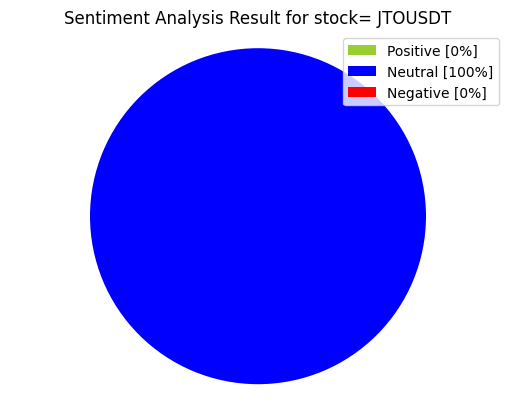

Searching for and analyzing CATIFDUSD, Please be patient, it might take a while...
Error processing article /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATI+FDUSD&spell=1: Article `download()` failed with No connection adapters were found for '/search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATI+FDUSD&spell=1' on URL /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATI+FDUSD&spell=1
Error processing article /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATIFDUSD&nfpr=1&sa=X&ved=2ahUKEwis2K-gqa6JAxXaRKQEHbxIJGAQvgV6BAgKEAI: Article `download()` failed with No connection adapters were found for '/search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATIFDUSD&nfpr=1&sa=

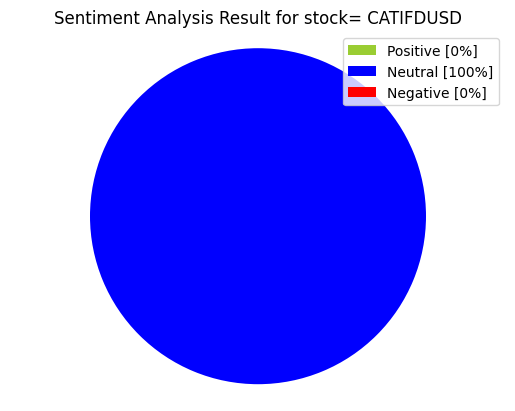

Searching for and analyzing CATIUSDT, Please be patient, it might take a while...
Error processing article /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATI+USDT&spell=1&sa=X&ved=2ahUKEwjDo8qkqa6JAxUeVqQEHQKVNgoQBXoECAoQAQ: Article `download()` failed with No connection adapters were found for '/search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATI+USDT&spell=1&sa=X&ved=2ahUKEwjDo8qkqa6JAxUeVqQEHQKVNgoQBXoECAoQAQ' on URL /search?lr=lang_en&sca_esv=ba1232cc7c24873f&hl=en&gl=en&biw=1920&bih=976&ucbcb=1&tbs=lr:lang_1en,sbd:1&tbm=nws&q=CATI+USDT&spell=1&sa=X&ved=2ahUKEwjDo8qkqa6JAxUeVqQEHQKVNgoQBXoECAoQAQ
Error processing article https://www.binance.com/fr-AF/square/post/15128409142281&ved=2ahUKEwjDo8qkqa6JAxUeVqQEHQKVNgoQxfQBegQIBRAC&usg=AOvVaw3XiNo2A_OLfq8YGVtOJhWy: You must `download()` an article first!
Error processing article https://www.binance.com/fr-AF

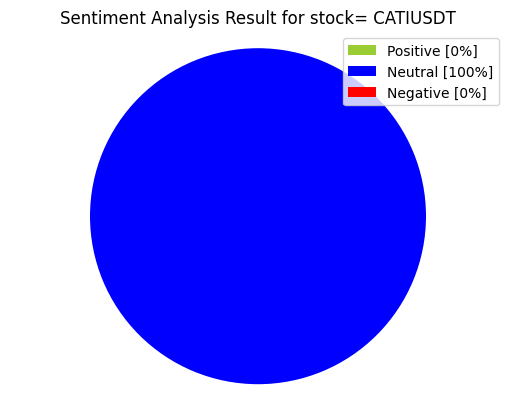

Searching for and analyzing CATITRY, Please be patient, it might take a while...
No articles found for the specified company.


NameError: name 'company_name' is not defined

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10

top_symbols_only = ['GFTUSDT', 'JTOUSDT', 'CATIFDUSD', 'CATIUSDT', 'CATITRY']

def analyze_sentiment(company_name):
    print(f'Searching for and analyzing {company_name}, Please be patient, it might take a while...')

    # Extract News with Google News
    googlenews = GoogleNews(start=yesterday, end=now)
    googlenews.search(company_name)
    result = googlenews.result()
    df = pd.DataFrame(result)

    # Initialize news_df to avoid UnboundLocalError
    news_df = pd.DataFrame()

    try:
        articles = []  # creating an empty list
        for i in df.index:
            article = Article(df['link'][i], config=config)  # providing the link
            try:
                article.download()  # downloading the article
                article.parse()  # parsing the article
                article.nlp()  # performing natural language processing (NLP)

                # Storing results in a dictionary
                dict = {
                    'Date': df['date'][i],
                    'Media': df['media'][i],
                    'Title': article.title,
                    'Article': article.text,
                    'Summary': article.summary,
                    'Key_words': article.keywords
                }
                articles.append(dict)
            except Exception as e:
                print(f"Error processing article {df['link'][i]}: {e}")

        if articles:  # Check if we have any articles
            news_df = pd.DataFrame(articles)  # creating dataframe
            print(news_df)
        else:
            print("No articles found for the specified company.")
            return  # Exit the function if no articles are found

    except Exception as e:
        print("Exception occurred: " + str(e))
        print('Looks like there is some error in retrieving the data. Please try again or try with a different ticker.')

    # Sentiment Analysis
    if not news_df.empty:  # Proceed only if news_df is not empty
        def percentage(part, whole):
            return 100 * float(part) / float(whole)

        # Assigning Initial Values
        positive = 0
        negative = 0
        neutral = 0
        news_list = []
        neutral_list = []
        negative_list = []
        positive_list = []

        # Iterating over the summaries in the dataframe
        for news in news_df['Summary']:
            news_list.append(news)
            analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
            neg = analyzer['neg']
            neu = analyzer['neu']
            pos = analyzer['pos']
            comp = analyzer['compound']

            if neg > pos:
                negative_list.append(news)
                negative += 1
            elif pos > neg:
                positive_list.append(news)
                positive += 1
            else:
                neutral_list.append(news)
                neutral += 1

        positive = percentage(positive, len(news_df))
        negative = percentage(negative, len(news_df))
        neutral = percentage(neutral, len(news_df))

        print("Positive Sentiment:", '%.2f' % len(positive_list))
        print("Neutral Sentiment:", '%.2f' % len(neutral_list))
        print("Negative Sentiment:", '%.2f' % len(negative_list))

        # Creating Pie Chart
        labels = [
            'Positive [' + str(round(positive)) + '%]',
            'Neutral [' + str(round(neutral)) + '%]',
            'Negative [' + str(round(negative)) + '%]'
        ]
        sizes = [positive, neutral, negative]
        colors = ['yellowgreen', 'blue', 'red']
        plt.pie(sizes, colors=colors, startangle=90)
        plt.legend(labels)
        plt.title("Sentiment Analysis Result for stock= " + company_name)
        plt.axis('equal')
        plt.show()

# Call the function for each symbol
for symbol in top_symbols_only:
    analyze_sentiment(symbol)

def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + company_name)
word_cloud(news_df['Summary'].values)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10

top_symbols_only = ['GFTUSDT', 'JTOUSDT', 'CATIFDUSD', 'CATIUSDT', 'CATITRY']

def analyze_sentiment(company_name):
    print(f'Searching for and analyzing {company_name}, Please be patient, it might take a while...')

    # Extract News with Google News
    googlenews = GoogleNews(start=yesterday, end=now)
    googlenews.search(company_name)
    result = googlenews.result()
    df = pd.DataFrame(result)

    # Initialize news_df to avoid UnboundLocalError
    news_df = pd.DataFrame()

    try:
        articles = []  # creating an empty list
        for i in df.index:
            article = Article(df['link'][i], config=config)  # providing the link
            try:
                article.download()  # downloading the article
                article.parse()  # parsing the article
                article.nlp()  # performing natural language processing (NLP)

                # Storing results in a dictionary
                dict = {
                    'Date': df['date'][i],
                    'Media': df['media'][i],
                    'Title': article.title,
                    'Article': article.text,
                    'Summary': article.summary,
                    'Key_words': article.keywords
                }
                articles.append(dict)
            except Exception as e:
                print(f"Error processing article {df['link'][i]}: {e}")

        if articles:  # Check if we have any articles
            news_df = pd.DataFrame(articles)  # creating dataframe
            print(news_df)
        else:
            print("No articles found for the specified company.")
            return  # Exit the function if no articles are found

    except Exception as e:
        print("Exception occurred: " + str(e))
        print('Looks like there is some error in retrieving the data. Please try again or try with a different ticker.')

    # Sentiment Analysis
    if not news_df.empty:  # Proceed only if news_df is not empty
        def percentage(part, whole):
            return 100 * float(part) / float(whole)

        # Assigning Initial Values
        positive = 0
        negative = 0
        neutral = 0
        news_list = []
        neutral_list = []
        negative_list = []
        positive_list = []

        # Iterating over the summaries in the dataframe
        for news in news_df['Summary']:
            news_list.append(news)
            analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
            neg = analyzer['neg']
            neu = analyzer['neu']
            pos = analyzer['pos']
            comp = analyzer['compound']

            if neg > pos:
                negative_list.append(news)
                negative += 1
            elif pos > neg:
                positive_list.append(news)
                positive += 1
            else:
                neutral_list.append(news)
                neutral += 1

        positive = percentage(positive, len(news_df))
        negative = percentage(negative, len(news_df))
        neutral = percentage(neutral, len(news_df))

        print("Positive Sentiment:", '%.2f' % len(positive_list))
        print("Neutral Sentiment:", '%.2f' % len(neutral_list))
        print("Negative Sentiment:", '%.2f' % len(negative_list))

        # Creating Pie Chart
        labels = [
            'Positive [' + str(round(positive)) + '%]',
            'Neutral [' + str(round(neutral)) + '%]',
            'Negative [' + str(round(negative)) + '%]'
        ]
        sizes = [positive, neutral, negative]
        colors = ['yellowgreen', 'blue', 'red']
        plt.pie(sizes, colors=colors, startangle=90)
        plt.legend(labels)
        plt.title("Sentiment Analysis Result for stock= " + company_name)
        plt.axis('equal')
        plt.show()

# Call the function for each symbol
for symbol in top_symbols_only:
    analyze_sentiment(symbol)

def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + company_name)
word_cloud(news_df['Summary'].values)